## Answering Business Questions Using SQL

We are going to use a SQLite database file called `chinook.db` to answer business questions.

## Introduction and Schema Diagram

In [1]:
# Load the sqlite database
%load_ext sql

In [2]:
%sql sqlite:///chinook.db

'Connected: @chinook.db'

This is the detail of a connection among databases:

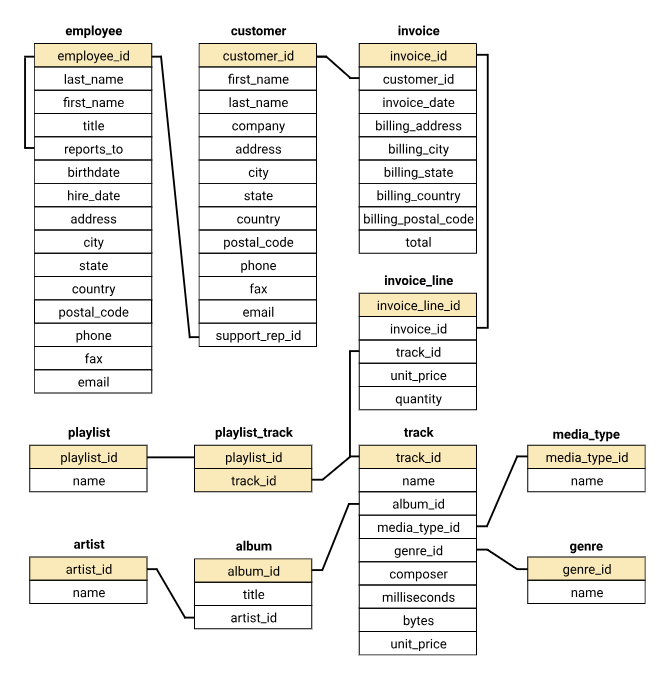

## Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don;t have any tracks in the store right now - we have the artist names, and the genre of music they produce:

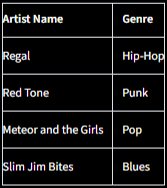

The record label specialized in artists from the US, and they have given Chinook some money to advertise the albums in the US, so we're interested in finding out which genres sell the best in the US.

So, we need to find out which genres sell the most tracks in the US, and make a recommendation for the three artists whose albums we should purchase for the store.

In [3]:
%%sql
WITH usa_tracks_sold AS
    (
        SELECT il.* FROM invoiceline il
        INNER JOIN invoice i ON il.InvoiceId = i.InvoiceId
        INNER JOIN customer c ON i.CustomerId = c.CustomerId
        WHERE c.Country == 'USA'
    )
    
SELECT g.Name genre,
        COUNT(uts.InvoiceLineId) track_sold,
        CAST(COUNT(uts.InvoiceLineId) AS FLOAT) / (SELECT COUNT(*) FROM usa_tracks_sold) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t ON t.TrackId = uts.TrackId
INNER JOIN genre g ON g.GenreId = t.GenreId
GROUP BY 1
ORDER BY 2 DESC
LIMIT 15;

 * sqlite:///chinook.db
Done.


genre,track_sold,percentage_sold
Rock,157,0.31781376518218624
Latin,91,0.18421052631578946
Metal,64,0.12955465587044535
Alternative & Punk,50,0.10121457489878542
Jazz,22,0.044534412955465584
Blues,15,0.030364372469635626
TV Shows,14,0.02834008097165992
R&B/Soul,12,0.024291497975708502
Comedy,8,0.016194331983805668
Classical,8,0.016194331983805668


Based on the data, we should select Red Tone (Punk), Slim Jim Bites (Blues), and Meteor and the Girls (Pop).

## Analyzing Employee Sales Performance

Each customer for the Chinook Store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performnig either better or worse than the others.

We are going to write a query that finds the total dollar amount of sales assigned to each sales support agent within the company.

In [4]:
%%sql
WITH employee_customer_relationship AS
    (
        SELECT i.CustomerId, c.SupportRepId, SUM(i.Total) total 
        FROM invoice i
        INNER JOIN customer c ON i.CustomerId = c.CustomerId
        GROUP BY 1
    )
    
SELECT e.FirstName || " " || e.LastName employee_name, SUM(ecr.total) total_sales 
FROM employee_customer_relationship ecr
INNER JOIN employee e ON ecr.SupportRepId = e.EmployeeId
GROUP BY 1;

 * sqlite:///chinook.db
Done.


employee_name,total_sales
Jane Peacock,833.0400000000001
Margaret Park,775.4000000000001
Steve Johnson,720.1600000000001


## Analyzing Sales by Country

In particular, we have been directed to calculate data, for each country, on the:

* total number of customers
* total value of sales
* average value of sales per customer
* average order value

Because there are a number of countries with only one customer, we should group these customers as "Other" in the analysis.

In [20]:
%%sql

WITH country_or_other AS
    (
     SELECT
        CASE
            WHEN
                (
                 SELECT COUNT(*)
                 FROM customer
                 WHERE country = c.Country
                ) = 1 THEN 'Other'
            ELSE c.Country
        END AS country,
        c.CustomerId,
        il.*
        FROM invoiceline il
        INNER JOIN invoice i ON il.InvoiceId = i.InvoiceId
        INNER JOIN customer c ON c.CustomerId = i.CustomerId
        
    )
    
SELECT country,
       total_customer,
       total_sales,
    average_sales_per_customer,
       average_order_value
        
FROM
    (
     SELECT
           country,
           COUNT(distinct CustomerId) total_customer,
           SUM(UnitPrice) total_sales,
           SUM(UnitPrice) / COUNT(distinct CustomerId) average_sales_per_customer,
           SUM(UnitPrice) / COUNT(distinct InvoiceId) average_order_value,
           CASE
            WHEN country = 'Other' THEN 1
            ELSE 0
           END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );   

 * sqlite:///chinook.db
Done.


country,total_customer,total_sales,average_sales_per_customer,average_order_value
USA,13,523.060000000003,40.235384615384845,5.747912087912121
Canada,8,303.96000000000134,37.99500000000017,5.4278571428571665
France,5,195.1000000000003,39.02000000000006,5.574285714285723
Brazil,5,190.10000000000028,38.02000000000005,5.4314285714285795
Germany,4,156.48,39.12,5.588571428571428
United Kingdom,3,112.85999999999979,37.619999999999926,5.374285714285704
Czech Republic,2,90.23999999999997,45.11999999999998,6.445714285714283
Portugal,2,77.23999999999997,38.61999999999998,5.517142857142855
India,2,75.25999999999999,37.629999999999995,5.789230769230769
Other,15,604.3000000000038,40.286666666666925,5.7552380952381315


So, in the results above we can see that these countries:

* Czech Republic
* India

that have the highest average dollar per order.